## Домашнее задание

1. *Самостоятельно повторить tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)
2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог)
3. Повторить п.2, но используя уже не медиану, а max
4. *Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (взяв список новостей пользователя)
    - подсказка 1: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал
    - подсказка 2: нужен именно idf, как вес.
5. Сформировать на выходе единую таблицу, сравнивающую качество 2/3 разных метода получения эмбедингов пользователей: median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

In [90]:
# предобработка текстов
import re
import numpy as np
from gensim.corpora.dictionary import Dictionary
from razdel import tokenize  # сегментация русскоязычного текста на токены и предложения https://github.com/natasha/razdel
import pymorphy2  # Морфологический анализатор
import pandas as pd
import nltk
from nltk.corpus import stopwords

In [91]:
news = pd.read_csv("articles.csv")

In [92]:
users = pd.read_csv("users_articles.csv")

In [93]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Intelit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [94]:
stopword_ru = stopwords.words('russian')


In [95]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
    
stopword_ru += additional_stopwords


In [96]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    text = re.sub('n', ' ', text)
    
    return text

cache = {}
morph = pymorphy2.MorphAnalyzer()

def lemmatization(text):    
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист лемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w) > 1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords = [i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [97]:
%%time
from tqdm import tqdm
tqdm.pandas()

# Запускаем очистку текста. Будет долго...
news['title'] = news['title'].progress_apply(lambda x: clean_text(x))

100%|███████████████████████████████████████████████████████████████████████████| 27000/27000 [00:41<00:00, 648.24it/s]

Wall time: 41.7 s


In [98]:
%%time
# Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].progress_apply(lambda x: lemmatization(x))

100%|████████████████████████████████████████████████████████████████████████████| 27000/27000 [06:02<00:00, 74.48it/s]

Wall time: 6min 2s


In [99]:
# сформируем список наших текстов
texts = list(news['title'].values)

# Создадим корпус из списка с текстами
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

In [100]:
N_topic = 10

In [101]:
%%time
from gensim.models import LdaModel

# Обучаем модель на корпусе
lda = LdaModel(common_corpus, num_topics=N_topic, id2word=common_dictionary, passes=5)

Wall time: 2min 42s


In [102]:
from gensim.test.utils import datapath

# Сохраняем модель на диск
temp_file = datapath("model.lda")
lda.save(temp_file)

In [103]:
# Загружаем обученную модель с диска
lda = LdaModel.load(temp_file)

In [104]:
def get_lda_vector(lda, text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]

    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(N_topic):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [105]:
%%time
topic_matrix = pd.DataFrame([get_lda_vector(lda, text) for text in news['title'].values])
topic_matrix.columns = [f'topic_{i}' for i in range(N_topic)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+[f'topic_{i}' for i in range(N_topic)]]
topic_matrix.head(5)

Wall time: 27.6 s


,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,6,0.159329,0.0,0.0,0.000000,0.619097,0.215264,0.000000,0.0,0.000000,0.000000
1,4896,0.553881,0.0,0.0,0.202748,0.000000,0.000000,0.027382,0.0,0.200974,0.000000
2,4897,0.725155,0.0,0.0,0.151617,0.000000,0.107605,0.000000,0.0,0.000000,0.000000
3,4898,0.837186,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.150752
4,4899,0.170261,0.0,0.0,0.035485,0.774726,0.000000,0.000000,0.0,0.000000,0.000000


In [106]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [107]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[[f'topic_{i}' for i in range(N_topic)]].values))

In [294]:
def get_user_embedding(user_articles_list, doc_dict):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    # print(user_vector)
    user_vector = np.mean(user_vector, 0)  # можно не среднее
    return user_vector

In [295]:
%%time
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, doc_dict))])
user_embeddings.columns = [f'topic_{i}' for i in range(N_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+[f'topic_{i}' for i in range(N_topic)]]
user_embeddings.head(3)

Wall time: 565 ms


,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,u105138,0.126728,0.086058,0.089963,0.011542,0.226985,0.077571,0.0,0.118285,0.038920,0.214449
1,u108690,0.146919,0.042286,0.094480,0.002055,0.268564,0.214397,0.0,0.174608,0.001925,0.050623
2,u108339,0.032394,0.027017,0.144422,0.023476,0.368926,0.095066,0.0,0.125902,0.008004,0.169823


In [296]:
user_embeddings.head()

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,u105138,0.126728,0.086058,0.089963,0.011542,0.226985,0.077571,0.0,0.118285,0.038920,0.214449
1,u108690,0.146919,0.042286,0.094480,0.002055,0.268564,0.214397,0.0,0.174608,0.001925,0.050623
2,u108339,0.032394,0.027017,0.144422,0.023476,0.368926,0.095066,0.0,0.125902,0.008004,0.169823
3,u101138,0.621607,0.029481,0.005062,0.089123,0.023783,0.099317,0.0,0.012250,0.009736,0.098525
4,u108248,0.103322,0.003375,0.255338,0.004935,0.296712,0.074867,0.0,0.091578,0.001968,0.163398


In [297]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [298]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,churn
0,u105138,0.126728,0.086058,0.089963,0.011542,0.226985,0.077571,0.0,0.118285,0.038920,0.214449,0
1,u108690,0.146919,0.042286,0.094480,0.002055,0.268564,0.214397,0.0,0.174608,0.001925,0.050623,1
2,u108339,0.032394,0.027017,0.144422,0.023476,0.368926,0.095066,0.0,0.125902,0.008004,0.169823,1


In [299]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [300]:
# разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[[f'topic_{i}' for i in range(N_topic)]], 
                                                    X['churn'], random_state=0)

In [301]:
logreg = LogisticRegression()
# обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [302]:
# наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.03092268, 0.01152877, 0.78294012, 0.0743296 , 0.03557639,
       0.06755709, 0.11623147, 0.01757732, 0.35908731, 0.1472552 ])

### Рассчитаем Precision, Recall, F_score

In [303]:
from sklearn.metrics import (f1_score, roc_auc_score, precision_score,
                             classification_report, precision_recall_curve, confusion_matrix)

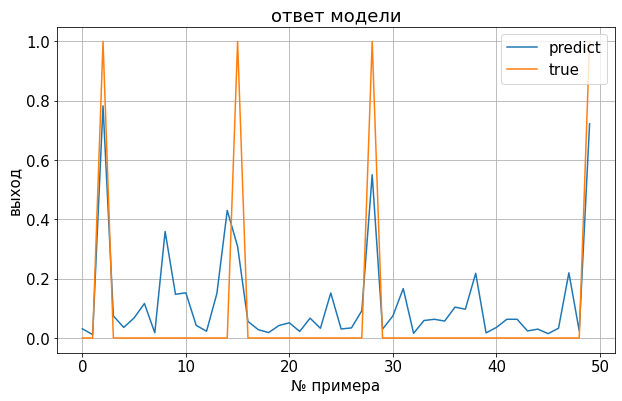

In [304]:
n = 50
plt.figure(figsize=(10, 6))
plt.plot(preds[:n], label='predict')
plt.plot(y_test.values[:n], label='true')
plt.title('ответ модели')
plt.xlabel('№ примера')
plt.ylabel('выход')
plt.legend()
plt.grid('On')
plt.show()

In [305]:
precision_mean, recall_mean, thresholds_mean = precision_recall_curve(y_test, preds)
fscore_mean = (2 * precision_mean * recall_mean) / (precision_mean + recall_mean)
# locate the index of the largest f score
ix_mean = np.argmax(fscore_mean)
print(f'Best Threshold_mean={thresholds_mean[ix_mean]}, F-Score_mean={fscore_mean[ix_mean]:.3f}, Precision_mean={precision_mean[ix_mean]:.3f}, Recall_mean={recall_mean[ix_mean]:.3f}')                                                                        

Best Threshold_mean=0.30133238752855207, F-Score_mean=0.766, Precision_mean=0.757, Recall_mean=0.776


In [306]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1754    1]
 [ 193   52]]


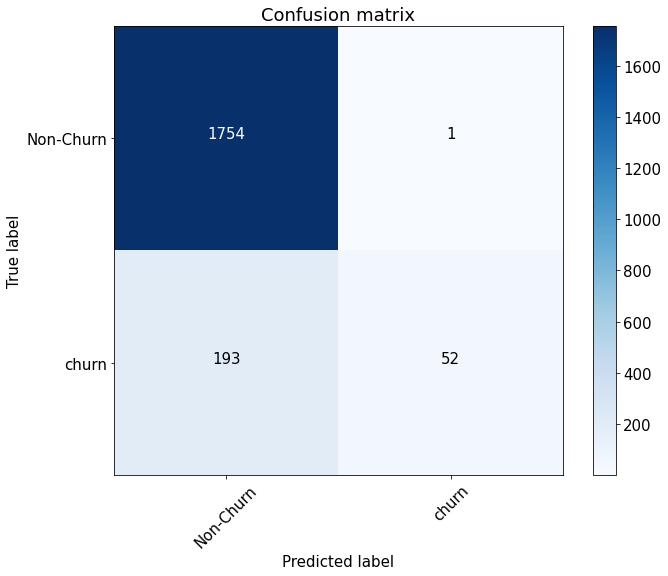

In [307]:
import itertools
# мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds > thresholds[ix])

plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [308]:
roc_mean = roc_auc_score(y_test, preds)

###  Использование медианы для преобразования

In [309]:
def get_user_embedding_median(user_articles_list, doc_dict):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    # print(user_vector)
    user_vector = np.median(user_vector, 0) 
    return user_vector

In [310]:
%%time
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_median(x, doc_dict))])
user_embeddings.columns = [f'topic_{i}' for i in range(N_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+[f'topic_{i}' for i in range(N_topic)]]

Wall time: 900 ms


In [311]:
X = pd.merge(user_embeddings, target, 'left')

In [312]:
X_train, X_test, y_train, y_test = train_test_split(X[[f'topic_{i}' for i in range(N_topic)]], 
                                                    X['churn'], random_state=0)

In [313]:
logreg = LogisticRegression()
# обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [314]:
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.04174604, 0.03690942, 0.6419754 , 0.07005215, 0.0494772 ,
       0.05744335, 0.23733251, 0.01493907, 0.17722067, 0.22101071])

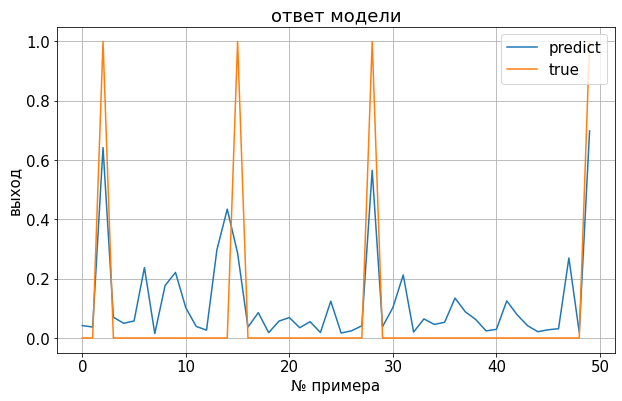

In [315]:
n = 50
plt.figure(figsize=(10, 6))
plt.plot(preds[:n], label='predict')
plt.plot(y_test.values[:n], label='true')
plt.title('ответ модели')
plt.xlabel('№ примера')
plt.ylabel('выход')
plt.legend()
plt.grid('On')
plt.show()

In [316]:
precision_median, recall_median, thresholds_median = precision_recall_curve(y_test, preds)
fscore_median = (2 * precision_median * recall_median) / (precision_median + recall_median)
# locate the index of the largest f score
ix_median = np.argmax(fscore_median)
print(f'Best Threshold_median={thresholds_median[ix_median]}, F-Score_median={fscore_median[ix_median]:.3f}, Precision_median={precision_median[ix_median]:.3f}, Recall_median={recall_median[ix_median]:.3f}')                                                                        

Best Threshold_median=0.26216905520896033, F-Score_median=0.725, Precision_median=0.674, Recall_median=0.784


In [317]:
roc_median = roc_auc_score(y_test, preds)

###  Использование max для преобразования

In [318]:
def get_user_embedding_max(user_articles_list, doc_dict):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    # print(user_vector)
    user_vector = np.max(user_vector, 0) 
    return user_vector

In [319]:
%%time
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_max(x, doc_dict))])
user_embeddings.columns = [f'topic_{i}' for i in range(N_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+[f'topic_{i}' for i in range(N_topic)]]

Wall time: 376 ms


In [320]:
X = pd.merge(user_embeddings, target, 'left')

In [321]:
X_train, X_test, y_train, y_test = train_test_split(X[[f'topic_{i}' for i in range(N_topic)]], 
                                                    X['churn'], random_state=0)

In [322]:
logreg = LogisticRegression()
# обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [323]:
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.0193757 , 0.0019576 , 0.77413518, 0.15066398, 0.03124343,
       0.01760623, 0.02381245, 0.06743256, 0.19653793, 0.10521315])

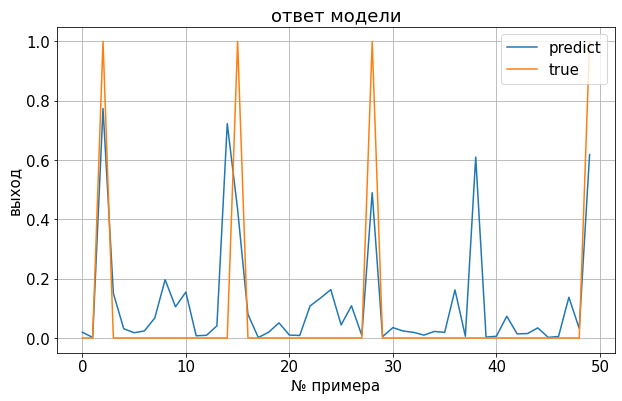

In [324]:
n = 50
plt.figure(figsize=(10, 6))
plt.plot(preds[:n], label='predict')
plt.plot(y_test.values[:n], label='true')
plt.title('ответ модели')
plt.xlabel('№ примера')
plt.ylabel('выход')
plt.legend()
plt.grid('On')
plt.show()

In [325]:
precision_max, recall_max, thresholds_max = precision_recall_curve(y_test, preds)
fscore_max = (2 * precision_max * recall_max) / (precision_max + recall_max)
# locate the index of the largest f score
ix_max = np.argmax(fscore_max)
print(f'Best Threshold_max={thresholds_max[ix_max]}, F-Score_max={fscore_max[ix_max]:.3f}, Precision_max={precision_max[ix_max]:.3f}, Recall_max={recall_max[ix_max]:.3f}')                                                                        

Best Threshold_max=0.36585646967101215, F-Score_max=0.642, Precision_max=0.655, Recall_max=0.629


In [326]:
roc_max = roc_auc_score(y_test, preds)

### Итог

In [327]:
print(f'Best Threshold_mean={thresholds_mean[ix_mean]}, F-Score_mean={fscore_mean[ix_mean]:.3f}, Precision_mean={precision_mean[ix_mean]:.3f}, Recall_mean={recall_mean[ix_mean]:.3f}, Roc_mean={roc_mean:.3f}')
print(f'Best Threshold_median={thresholds_median[ix_median]}, F-Score_median={fscore_median[ix_median]:.3f}, Precision_median={precision_median[ix_median]:.3f}, Recall_median={recall_median[ix_median]:.3f},  Roc_median={roc_median:.3f}')                                                                        
print(f'Best Threshold_max={thresholds_max[ix_max]}, F-Score_max={fscore_max[ix_max]:.3f}, Precision_max={precision_max[ix_max]:.3f}, Recall_max={recall_max[ix_max]:.3f},  Roc_max={roc_max:.3f}') 

Best Threshold_mean=0.30133238752855207, F-Score_mean=0.766, Precision_mean=0.757, Recall_mean=0.776, Roc_mean=0.970
Best Threshold_median=0.26216905520896033, F-Score_median=0.725, Precision_median=0.674, Recall_median=0.784,  Roc_median=0.959
Best Threshold_max=0.36585646967101215, F-Score_max=0.642, Precision_max=0.655, Recall_max=0.629,  Roc_max=0.933


### Вывод

На сколько я понял, беря среднее значение, мы вычисляем на сколько в среднем, пользователь интересуется конкретным топиком( темой новостей), т.е. фактически получается вероятность заинтересовать пользователя определенной темой.
Так, например, если мы берем максимальное значение, то мы акцентируем внимание на том, на сколько хорошо алгоритм описал топики, но не обобщаем предпочтения человека. Например из 7 новостей одного человека берем первую, и она на 0.7 пренадлежит описанию котиков, остальные  ~равномерно распределены на другие топики, но на футбол там всегда максимальная вероятность, и она 0.3. Таким образом у нас получится, будто пользователь интереснуется котиками в 2 раза сильнее, чем футболом, хотя на новость про котиков он мог и случайно нажать.
Медиана ближе к среднему, и имеет более обобщающую способность, нежели максимальное значение, потому и качество выше.

Исходя из всего выше сказанного, я делаю вывод, что среднее значение лучший метод.